# Graph Classification Code Example

### Shyam Sundaram, Thejas Sairam, Shrikumar Shankar

Reference provided below in the references section

# Installing required Libaries 

In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

# Graph Classification using Graph Neural Networks

In this session we will have a closer look at how to apply **Graph Neural Networks (GNNs) to the task of graph classification**.
Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.

Here, we want to embed entire graphs, and we want to embed those graphs in such a way, that all the structural information of the graphs are captured by the GNNs

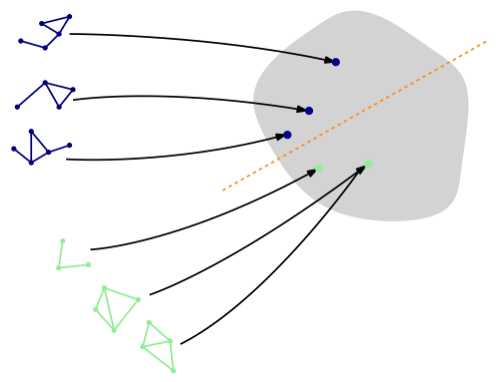

The most common task for graph classification is **molecular property prediction**, in which molecules are represented as graphs (refer image below). Let's take an example and try to solve this class of problem.

molecule_graph.svg

The TU Dortmund University has collected a wide range of different graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.
Let's load and inspect one of the smaller ones, the **MUTAG dataset**:

# Importing Libraries

In [ ]:
import torch
from torch_geometric.datasets import TUDataset

# Importing and Understanding Dataset

The MUTAG Dataset is a collection of nitroaromatic compounds and the goal is to predict their **mutagenicity** (susceptible to Mutation or not) on **Salmonella typhimurium.** 

Input graphs are used to represent chemical compounds, where vertices stand for atoms and are labeled by the atom type (represented by one-hot encoding), while edges between vertices represent bonds between the corresponding atoms. 

It includes 188 samples of chemical compounds with 7 discrete node labels (C, N, O, F, I, Cl, Br) and the task is to classify each graph into one out of two classes. **1 indicating mutagenicity** and **0 meaning no mutagenicity.** 

**Some Additional Data Points [Ref 2]**
> * Graph contains 188 graphs with 18 nodes and 20 edges on average for each graph. 
* The graph nodes have 7 different labels/atom types, and the binary graph labels represent “their mutagenic effect on a specific gram negative bacterium” (the specific meaning of the labels are not too important here).

In [ ]:
# Importing Dataset using the TUDataset Library of Pytorch Geometric
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

#Get Basic Information about the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features} (One hot encoded)')
print(f'Number of classes: {dataset.num_classes} (1: Mutagenicity, 0: No mutagenicity)')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7 (One hot encoded)
Number of classes: 2 (1: Mutagenicity, 0: No mutagenicity)


By Inspecting the first Graph object we can see that the graph has 
* **17 nodes/atoms (7-dimensional since features are one hot encoded)** and **38 edges**. 
* And it comes with **exactly one label (`y=[1]`)**.
* Has **no isolated nodes** i.e. all nodes are connected.
* Has **no self loops** (No atom can be connected to itself)

In [ ]:
# Get the first graph object/Molecule.
data = dataset[0]

#Prints information about the data tensor of 1st Graph object
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


##Visual representation of 17x7 node features.

**Node Labels**

*  0: C
*  1: N
*  2: O
*  3: F
*  4: I
*  5: Cl
*  6: Br


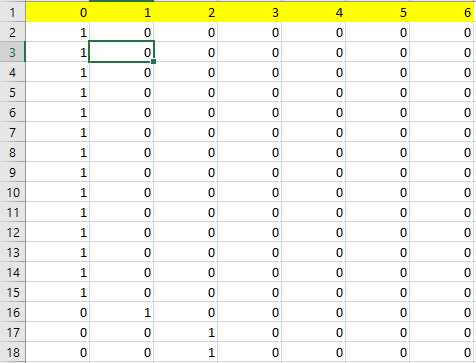

In [ ]:
print(data.x)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]])


##Visual Representation of Edge Index

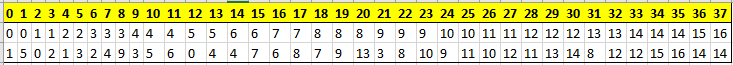

**Note**
* **Here Column 0 represents Edge 0 indicating Node 0 is connected to Node 1** and so on.
* Since there are 38 edges for 1st Graph/Molecule, we have 38 columns.
* Also Notice, since 1st Graph/Molecule has 17 Nodes/atoms, the values in edge index range from **0 to 16.**

In [ ]:
print(data.edge_index)

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])


## Visual Representation of Molecule 1

Using the Node Labels and Edge Index mentioned above, this is the rough structure of Graph/Molecule 1.

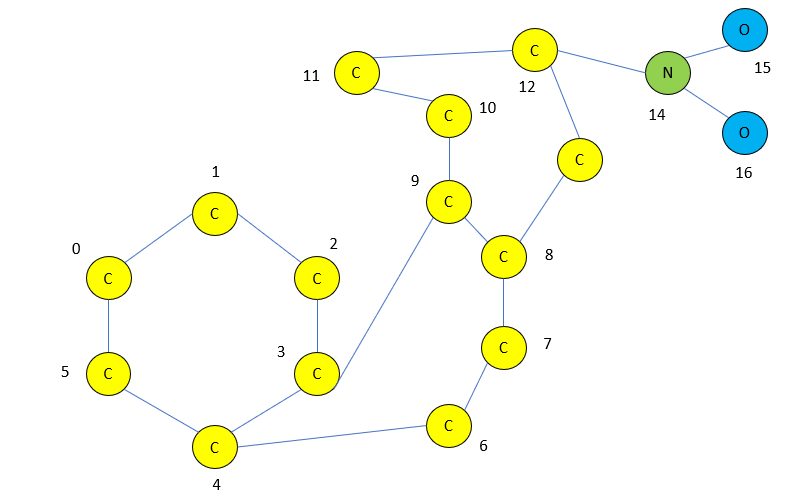





# Train and Test Split

PyTorch Geometric provides some useful utilities for working with graph datasets, *e.g.*, we can shuffle the dataset and use **the first 150 graphs as training graphs, while using the remaining ones for testing**

In [ ]:
#Shuffling Dataset
torch.manual_seed(12345)
dataset = dataset.shuffle()

#Splitting into train and test dataset
# First 150 -> Train
# Remaining (38) -> Test
train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.

We encounter a problem with batching **N(=64)** graphs. Each graph in the batch can have a different number of nodes and edges, and hence we would require a lot of padding to obtain a single tensor.

Pytorch Geometric opts an approach in which 
* the **adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs)**, 
* node and target features are simply concatenated in the node dimension

**Description**
>* X1: Features of 1st Graph/Molecule
* A1: Adjacency Matrix (Graph Structure) of 1st Graph/Molecule
* X2: Features of 2nd Graph/Molecule
* A1: Adjacency Matrix (Graph Structure) of 2nd Graph/Molecule
* X'1: Label predicted by GNN for 1st Graph/Molecule
* X'2: Label predicted by GNN for 2nd Graph/Molecule

* **The Adjacency Matrices** of 1st and 2nd Graph/Molecule are **stacked Diagonally**
* **Features** are represented as **Vectors** and passed into the GNN

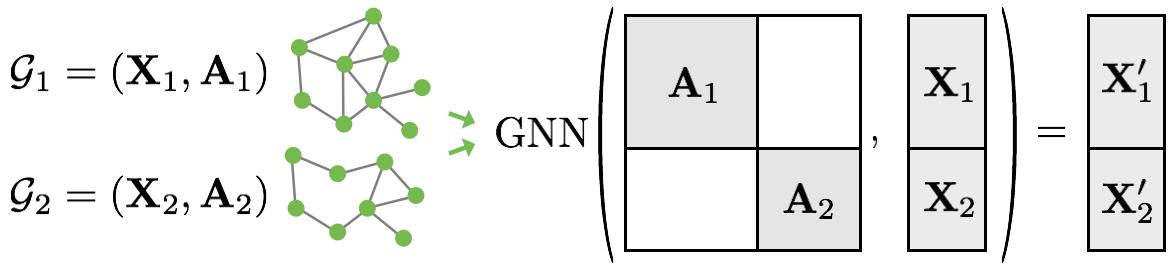

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

Here, we opt for a `batch_size` of 64, leading to 3 (randomly shuffled) mini-batches, containing all $2 \cdot 64+22 = 150$ graphs.

Furthermore, each `Batch` object is equipped with a `batch` **vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$

In [ ]:
#Library for batching Graphs
from torch_geometric.loader import DataLoader

#Batching train and test dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#Creates 3 set of batches with 64 graphs each
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



Lets take an example of Batch 1 and understand its attributes 

* **Number of graphs in the current batch:** 64
* **edge_index**=[2, 2636] (Contains edges of all 64 graphs present in Batch 1)
* **x**=[1188, 7] (Contains nodes of all 64 graphs present in Batch 1)
* **y**=[64] (Labels of all 64 graphs)
* **batch**=[1188] (Refer cell below to understand)

In [ ]:
#Batch object for Mini-Batch Number 1
# 0 Indicates Node/Atom is of 1st Graph/Molecule of Batch 1, 1 Indicates Node/Atom is of 2nd Graph/Molecule etc.
data.batch[:350]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 13, 13, 13, 13, 13, 13, 

# Creating a Graph Neural Network

The final architecture for applying GNNs to the task of graph classification looks as follows and allows for complete end-to-end training

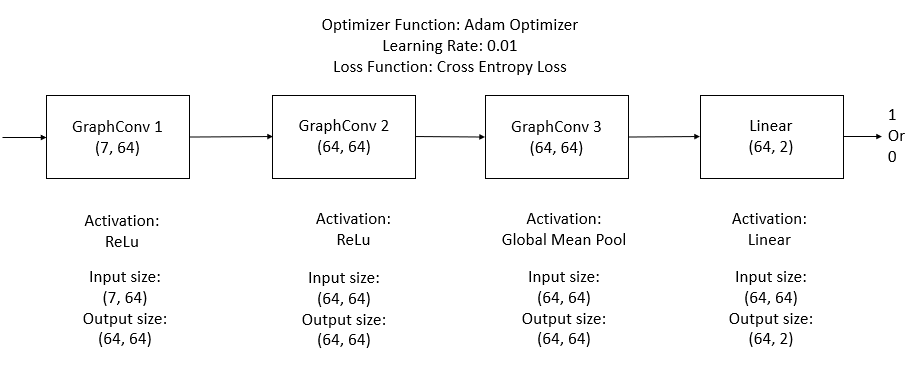

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


# Training Graph Neural Network

Training a GNN for graph classification usually follows the steps mentioned below:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings.

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

Here, we make use of the [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

**Every atom (Node for a graph object) gets an embedding and overall average across all the atom embedding gets computed which becomes the molecule embedding value.**

In [ ]:
#Instantiating a model
model = GCN(hidden_channels=64)

#Creating Optimizer with Learning rate 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#Criteria for Loss calculation
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def train():
  """
  Function to train the GCN Model
  Does the following steps
    1. Iterate in batches over the training dataset
    2. Perform a single forward pass
    3. Compute the Cross Entropy Loss
    4. Derive Gradients
    5. Update parameters based on gradients
    6. Clear Gradients
  """
  model.train()

  # Iterate in batches over the training dataset.
  for data in train_loader:  
        # Perform a single forward pass.
        out = model(data.x, data.edge_index, data.batch)
        # Compute the loss.
        loss = criterion(out, data.y)
        # Derive gradients.  
        loss.backward()
        # Update parameters based on gradients.  
        optimizer.step() 
        # Clear gradients. 
        optimizer.zero_grad()  

In [ ]:
def test(loader):
  """
  Function to Test the model
  Does the following steps
    1. Iterate in batched over the training/test dataset
    2. Get predictions
    3. Get the class with highest probability
    4. Check against ground-truth labels
    5. Derive ratio of correct predictions (accuracy)
  """
  model.eval()

  correct = 0
  for data in loader:  # Iterate in batches over the training/test dataset.
      out = model(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred == data.y).sum())  # Check against ground-truth labels.
  return correct / len(loader.dataset)  # Derive ratio of correct predictions.

**Note**
> * The Number of Epochs has been chosen randomly
* In each Epoch the model is trained on the 3 Mini-batches

In [ ]:
for epoch in range(1, 171):
  train()
  train_acc = test(train_loader)
  test_acc = test(test_loader)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.7333, Test Acc: 0.7895
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.7333, Test Acc: 0.8158
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.8158
Epoch: 009, Train Acc: 0.7867, Test Acc: 0.8421
Epoch: 010, Train Acc: 0.7733, Test Acc: 0.8158
Epoch: 011, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 012, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 013, Train Acc: 0.7733, Test Acc: 0.8421
Epoch: 014, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 015, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 016, Train Acc: 0.7667, Test Acc: 0.7632
Epoch: 017, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 018, Train Acc: 0.7867, Test Acc: 0.7895
Epoch: 019, Train Acc: 0.7867, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.8133, Test Acc: 0.8421
Epoch: 021, Train Acc: 0.8000, Test Acc:

After training, our model achieves an Test accuracy of **81.58%.**

# Conclusion

In this chapter, you have learned how to apply GNNs to the task of graph classification.
You have learned how graphs can be batched together for better GPU utilization, and how to apply readout layers for obtaining graph embeddings rather than node embeddings.

# References
* Base Code: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html#Graph-level-tasks:-Graph-classification
* [Ref 2] TU Datasets: https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset
* DataLoader: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader
* GraphConv: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv
* https://arxiv.org/pdf/1911.08941.pdf
